In [1]:
import os
import numpy as np
import cv2  # Ensure OpenCV is imported
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2,EfficientNetB0
import pickle
import keras

2024-07-17 06:05:09.969964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 06:05:09.970103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 06:05:10.117776: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
keras.__version__

'3.3.3'

In [3]:
# Path to your dataset
IMAGE_PATH = '/kaggle/input/palm-niki2/PLSU/img'
MASK_PATH = '/kaggle/input/palm-niki2/PLSU/Mask'

In [4]:
# Set parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 8
BUFFER_SIZE = 1000
EPOCHS = 20

In [5]:
# Set parameters
IMG_HEIGHT = 384
IMG_WIDTH = 384
BATCH_SIZE = 4
BUFFER_SIZE = 1000
EPOCHS = 20

In [6]:
# Function to load and preprocess images and masks
def load_image(image_path, mask_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    mask = np.expand_dims(mask, axis=-1)
    mask = mask / 255.0

    return image, mask

In [7]:
def load_data(image_folder, mask_folder):
    image_paths = sorted([os.path.join(image_folder, fname) for fname in os.listdir(image_folder)])
    mask_paths = sorted([os.path.join(mask_folder, fname) for fname in os.listdir(mask_folder)])

    images = []
    masks = []

    for img_path, msk_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths)):
        img, msk = load_image(img_path, msk_path)
        images.append(img)
        masks.append(msk)

    return np.array(images), np.array(masks)

In [8]:
# Load data
images, masks = load_data(IMAGE_PATH, MASK_PATH)

100%|██████████| 1439/1439 [02:01<00:00, 11.83it/s]


In [9]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [10]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [11]:
def preprocess(image, mask):
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    mask = tf.image.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    return image, mask

In [12]:
train_dataset = train_dataset.map(preprocess).batch(BATCH_SIZE).shuffle(BUFFER_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [13]:
@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    denominator = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice_score = (2. * intersection + smooth) / (denominator + smooth)
    return 1 - dice_score

In [14]:
def unet_model(output_channels, img_height, img_width):
    inputs = tf.keras.layers.Input(shape=[img_height, img_width, 3])
    
    # Encoder: Use MobileNetV2 as the feature extractor
    encoder = tf.keras.applications.MobileNetV2(input_shape=[img_height, img_width, 3], include_top=False, weights='imagenet')
    encoder.trainable = True  # Allow fine-tuning
    
    # Unfreeze some of the higher layers in the encoder
    for layer in encoder.layers[-40:]:
        layer.trainable = True

    # Use the layers to create skip connections
    layer_names = [
        'block_1_expand_relu',   # 128x128
        'block_3_expand_relu',   # 64x64
        'block_6_expand_relu',   # 32x32
        'block_13_expand_relu',  # 16x16
        'block_16_project',      # 8x8
    ]

    layers = [encoder.get_layer(name).output for name in layer_names]
    down_stack = tf.keras.Model(inputs=encoder.input, outputs=layers)
    down_stack.trainable = True

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Decoder: Use Conv2DTranspose layers to upsample with Batch Normalization and Dropout
    up_stack = [
        512,  # 8x8 -> 16x16
        256,  # 16x16 -> 32x32
        128,  # 32x32 -> 64x64
        64,   # 64x64 -> 128x128
    ]

    for up, skip in zip(up_stack, skips):
        x = tf.keras.layers.Conv2DTranspose(up, 3, strides=2, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        
        # Additional convolutional layers for better feature extraction
        x = tf.keras.layers.Conv2D(up, 3, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)

    # Output layer with activation depending on the task (e.g., 'sigmoid' for binary, 'softmax' for multi-class)
    x = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, padding='same', activation='sigmoid')(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [15]:
# Instantiate and compile the model
output_channels = 1
model = unet_model(output_channels,IMG_HEIGHT,IMG_WIDTH)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=dice_loss, metrics=['accuracy'])

/tmp/ipykernel_34/2740779134.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  encoder = tf.keras.applications.MobileNetV2(input_shape=[img_height, img_width, 3], include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("unet.keras", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

In [17]:
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/20


I0000 00:00:1721196561.555170     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


288/288 ━━━━━━━━━━━━━━━━━━━━ 197s 352ms/step - accuracy: 0.5938 - loss: 0.9837 - val_accuracy: 0.9080 - val_loss: 0.9769
Epoch 2/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - accuracy: 0.7597 - loss: 0.9706 - val_accuracy: 0.9313 - val_loss: 0.9649
Epoch 3/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 40s 138ms/step - accuracy: 0.8368 - loss: 0.9657 - val_accuracy: 0.9263 - val_loss: 0.9573
Epoch 4/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - accuracy: 0.8740 - loss: 0.9605 - val_accuracy: 0.9328 - val_loss: 0.9517
Epoch 5/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - accuracy: 0.9095 - loss: 0.9552 - val_accuracy: 0.9352 - val_loss: 0.9486
Epoch 6/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - accuracy: 0.9362 - loss: 0.9492 - val_accuracy: 0.9421 - val_loss: 0.9436
Epoch 7/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 40s 138ms/step - accuracy: 0.9502 - loss: 0.9432 - val_accuracy: 0.9603 - val_loss: 0.9380
Epoch 8/20
288/288 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - accuracy: 0.9655 - loss: 0.9375 - va

In [18]:
pickle.dump(model,open("model.pkl","wb"))
model.save('model.h5')

In [19]:
# Evaluate the model
loss, acc = model.evaluate(val_dataset)
print(f"Validation loss: {loss}")
print(f"Validation accuracy: {acc}")

72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9886 - loss: 0.7725
Validation loss: 0.7725549340248108
Validation accuracy: 0.9885496497154236


In [20]:
# Visualize predictions
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ["Input Image", "True Mask", "Dilated Mask", "Eroded Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        if i == 0:  # Input image
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:  # Masks
            plt.imshow(display_list[i], cmap='gray')
        plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


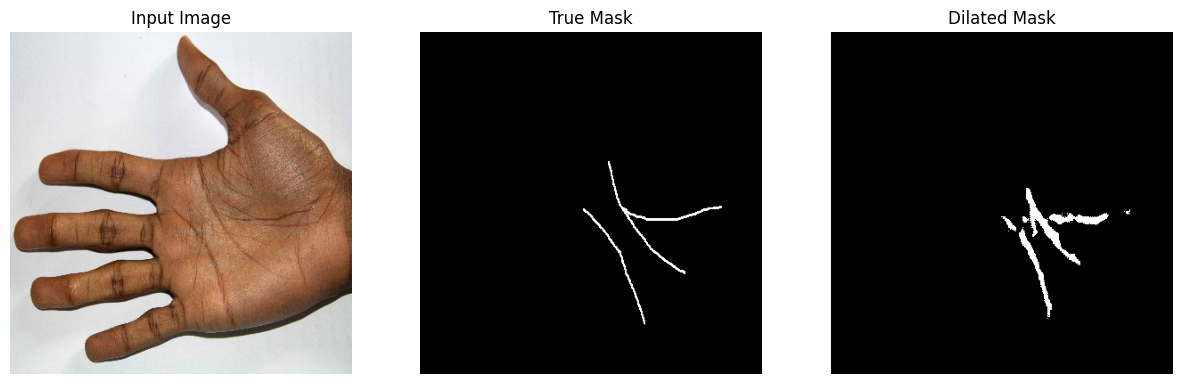

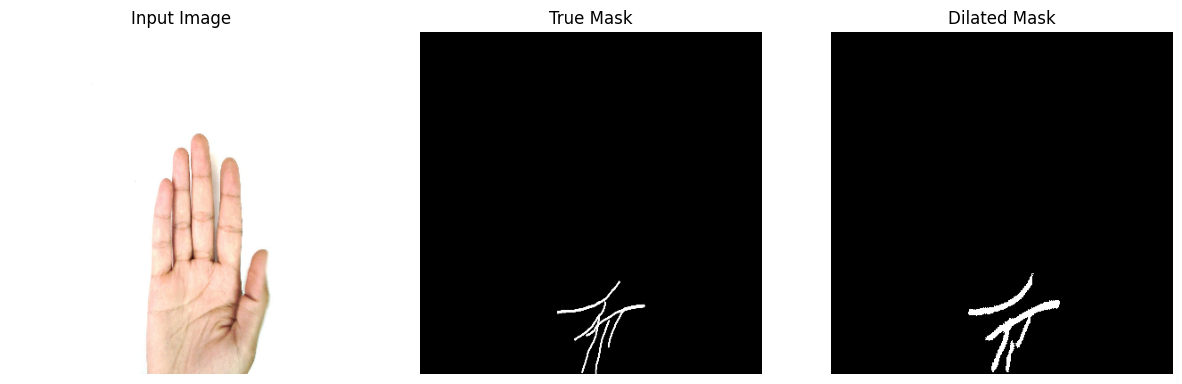

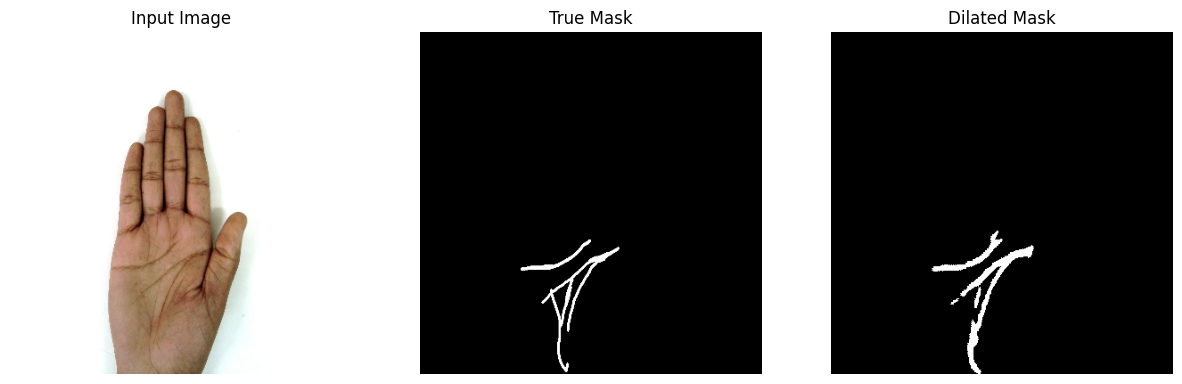

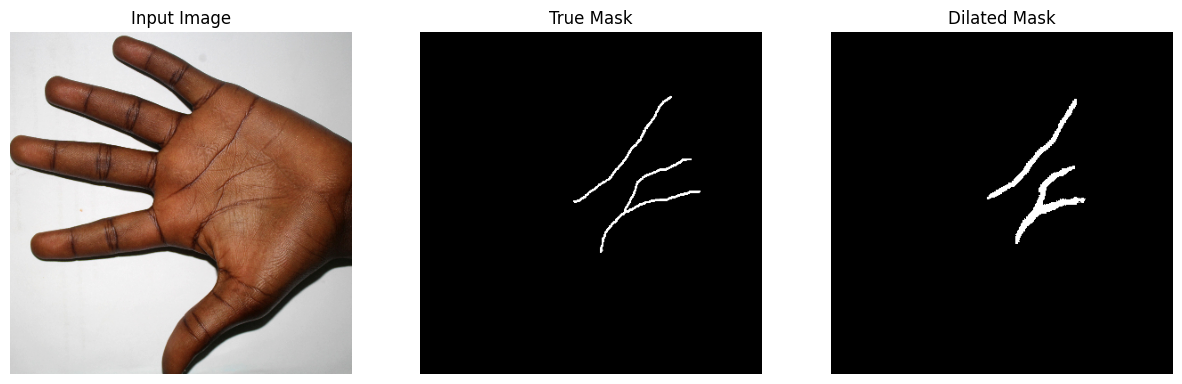

In [21]:
for images, masks in val_dataset.take(1):
    pred_masks = model.predict(images)
    pred_masks = (pred_masks > 0.5).astype(np.uint8)
    for i in range(4):
        display([images[i], masks[i], pred_masks[i]])

In [22]:
# Function to dilate the mask
def dilate_mask(mask, kernel_size=2):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_mask = cv2.dilate(mask, kernel, iterations=2)
    return dilated_mask

# Function to erode the mask
def erode_mask(mask, kernel_size=4):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded_mask = cv2.erode(mask, kernel, iterations=1)
    return eroded_mask

In [23]:
# Function to preprocess and predict mask for a single new image
def predict_mask(image_path, model):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    
    pred_mask = model.predict(image)
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    pred_mask = np.squeeze(pred_mask, axis=0)
    
    dilated_mask = dilate_mask(pred_mask)
    eroded_mask = erode_mask(dilated_mask)
    
    return image[0], pred_mask, dilated_mask, eroded_mask

In [24]:
# Predict mask for a new image
new_image_path = '/kaggle/input/hand-img/3.jpg'
input_image, predicted_mask, dilated_mask, eroded_dilated_mask = predict_mask(new_image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


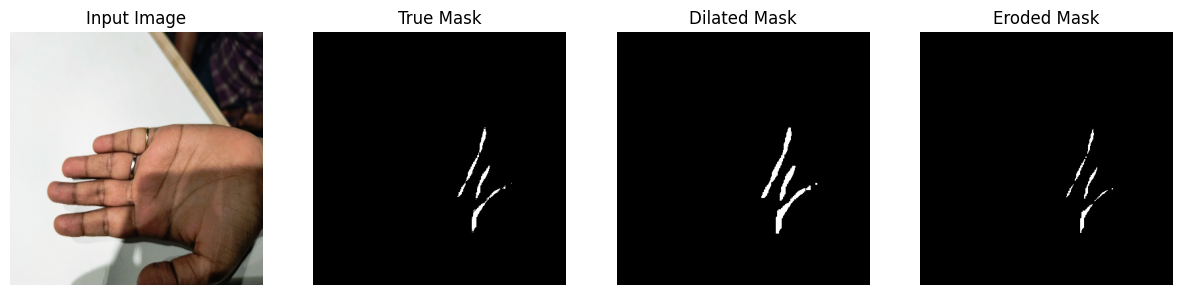

In [25]:
display([input_image, predicted_mask, dilated_mask, eroded_dilated_mask])

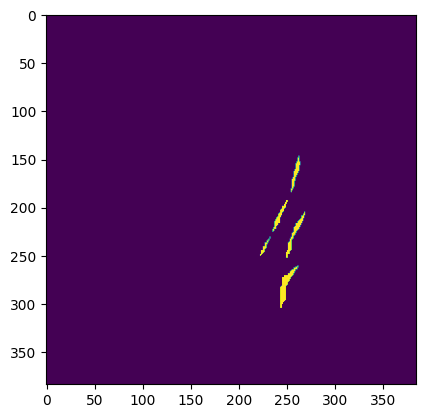

In [26]:
# Find contours
contours, _ = cv2.findContours(eroded_dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours based on area
min_contour_area = 20  # Adjust this threshold as needed
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]



# Create an empty mask
mask = np.zeros_like(eroded_dilated_mask)


# Draw filtered contours on the mask
cv2.drawContours(mask, [cnt for cnt in filtered_contours], -1, (255), thickness=cv2.FILLED)


plt.imshow(mask)
plt.show()

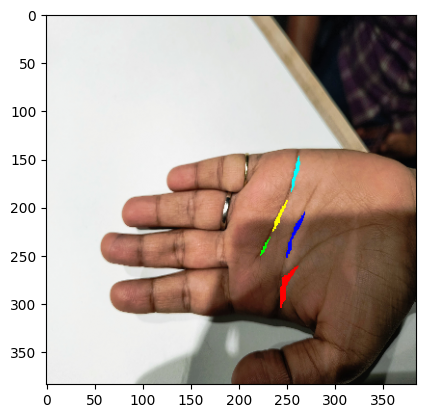

In [27]:
# Overlay mask on original image
overlay = input_image.copy()
# Define a list of colors (in BGR format)
colors = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255),
    (255, 255, 0), (0, 255, 255), (255, 0, 255),
    (128, 0, 0), (0, 128, 0), (0, 0, 128),
    (128, 128, 0), (0, 128, 128), (128, 0, 128)
]
# Draw each contour with a different color
for i, cnt in enumerate(filtered_contours):
    color = colors[i % len(colors)]  # Cycle through colors
    cv2.drawContours(overlay, [cnt], -1, color, thickness=cv2.FILLED)
    
plt.imshow(overlay)
plt.show()

In [28]:
# Find contours again on the dilated mask
contours_final = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

In [29]:
# Find the lengths of the remaining contours
for i, cnt in enumerate(contours_final):
    arc_length = cv2.arcLength(cnt, True)
    print("Length of contour {}: {}".format(i+1, arc_length))

Length of contour 1: 106.7695517539978
Length of contour 2: 48.041630029678345
Length of contour 3: 112.08326017856598
Length of contour 4: 78.76955199241638
Length of contour 5: 81.4558436870575
